## Derivation of 10-state EKF

From AHRS (https://ahrs.readthedocs.io/en/latest/filters/ekf.html)

#### Prediction
Quaternion Dynamics:
$$\begin{split}\begin{array}{rcl}
\hat{\mathbf{q}}_t &=& \mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t) \\
&=&\Big(\mathbf{I}_4 + \frac{\Delta t}{2}\boldsymbol\Omega_t\Big)\mathbf{q}_{t-1} \\
\begin{bmatrix}\hat{q_w} \\ \hat{q_x} \\ \hat{q_y} \\ \hat{q_z}\end{bmatrix}
&=&
\begin{bmatrix}
    q_w - \frac{\Delta t}{2} \omega_x q_x - \frac{\Delta t}{2} \omega_y q_y - \frac{\Delta t}{2} \omega_z q_z\\
    q_x + \frac{\Delta t}{2} \omega_x q_w - \frac{\Delta t}{2} \omega_y q_z + \frac{\Delta t}{2} \omega_z q_y\\
    q_y + \frac{\Delta t}{2} \omega_x q_z + \frac{\Delta t}{2} \omega_y q_w - \frac{\Delta t}{2} \omega_z q_x\\
    q_z - \frac{\Delta t}{2} \omega_x q_y + \frac{\Delta t}{2} \omega_y q_x + \frac{\Delta t}{2} \omega_z q_w
\end{bmatrix}
\end{array}\end{split}$$

State Jacobian:
$$\begin{split}\begin{array}{rcl}
\mathbf{F}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)
&=& \frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial\mathbf{q}} \\
&=&\begin{bmatrix}
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial q_w} &
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial q_x} &
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial q_y} &
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial q_z}
\end{bmatrix}
\end{array}\end{split}
$$

NOTE This jacobian is wrong - needs to be multplied by the full state and not just the quaternion

Process Noise Covariance:
$$\hat{\mathbf{P}}_t = \mathbf{F}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)\mathbf{P}_{t-1}\mathbf{F}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)^T + \mathbf{Q}_t$$
$$\begin{split}\begin{array}{rcl}
\mathbf{W}_t &=& \frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial\boldsymbol\omega} \\
&=& \begin{bmatrix}
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial\omega_x} &
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial\omega_y} &
\frac{\partial\mathbf{f}(\mathbf{q}_{t-1}, \boldsymbol\omega_t)}{\partial\omega_z}
\end{bmatrix} \\
&=& \frac{\Delta t}{2}
\begin{bmatrix}
-q_x & -q_y & -q_z \\
q_w & -q_z & q_y \\
q_z & q_w & -q_x \\
-q_y & q_x & q_w
\end{bmatrix}
\end{array}\end{split}$$

$$\mathbf{Q}_t = \sigma_\boldsymbol\omega^2\mathbf{W}_t\mathbf{W}_t^T$$

#### Correction
Measurement Matrix:
$$\mathbf{q}_t = \hat{\mathbf{q}}_t + \mathbf{K}_t \big(\mathbf{z}_t - \mathbf{h}(\mathbf{q}_t)\big)$$
$$\begin{split}\mathbf{z}_t =
\begin{bmatrix}\mathbf{a}_t \\ \mathbf{m}_t \\ \textbf{pos}_{\text{gps}} \\ \textbf{vel}_{\text{gps}}\end{bmatrix}\end{split}$$

H Matrix:
$$\begin{split}\begin{array}{rcl}
\mathbf{h}(\hat{\mathbf{q}}_t) &=& \begin{bmatrix}\hat{\mathbf{a}} \\ \hat{\mathbf{m}}\end{bmatrix}
= \begin{bmatrix}\mathbf{C}(\hat{\mathbf{q}})^T \mathbf{g} \\ \mathbf{C}(\hat{\mathbf{q}})^T \mathbf{r}\end{bmatrix}
\end{array}\end{split}$$

$\textbf{g}$ is the gravitational reference and $\textbf{r}$ is the magnetic field reference including inclination and declination.

In [13]:
import struct
import math
import time
import csv

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt

from scipy.spatial.transform import Rotation as R
from ahrs.common.orientation import acc2q
from ahrs import Quaternion

In [14]:
## Parse configs
#max_iter = 125
max_iter = None

def parse(frame, ctx):
    #print(f"pkt found {len(frame)} {frame[2]}")
    if frame[2]==0x01:
        roll, pitch, yaw = struct.unpack('<fff', frame[4:])
        ctx['roll'].append(roll)
        ctx['pitch'].append(pitch)
        ctx['yaw'].append(yaw)

    elif frame[2]==0x02:
        pos_x, pos_y, pos_z = struct.unpack('<fff', frame[4:])
        ctx['pos_x'].append(pos_x)
        ctx['pos_y'].append(pos_y)
        ctx['pos_z'].append(pos_z)

    elif frame[2]==0x03:
        vel_x, vel_y, vel_z = struct.unpack('<fff', frame[4:])
        ctx['vel_x'].append(vel_x)
        ctx['vel_y'].append(vel_y)
        ctx['vel_z'].append(vel_z)

    elif frame[2]==0x04:
        er_x, er_y, er_z = struct.unpack('<fff', frame[4:])
        ctx['er_x'].append(er_x)
        ctx['er_y'].append(er_y)
        ctx['er_z'].append(er_z)

    elif frame[2]==0x05:
        force, rt, pt, yt = struct.unpack('<ffff', frame[4:])
        ctx['force'].append(force)
        ctx['rt'].append(rt)
        ctx['pt'].append(pt)
        ctx['yt'].append(yt)

    elif frame[2]==0x06:
        m0, m1, m2, m3 = struct.unpack('<hhhh', frame[4:])
        ctx['m0'].append(m0)
        ctx['m1'].append(m1)
        ctx['m2'].append(m2)
        ctx['m3'].append(m3)

    elif frame[2]==0x07:
        accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, comp_x, comp_y, comp_z = struct.unpack('<fffffffff', frame[4:])
        ctx['accel_x'].append(accel_x)
        ctx['accel_y'].append(accel_y)
        ctx['accel_z'].append(accel_z)
        ctx['gyro_x'].append(gyro_x)
        ctx['gyro_y'].append(gyro_y)
        ctx['gyro_z'].append(gyro_z)
        ctx['comp_x'].append(comp_x)
        ctx['comp_y'].append(comp_y)
        ctx['comp_z'].append(comp_z)

    elif frame[2]==0x08:
        pos_x_a, pos_y_a, pos_z_a, vel_x_a, vel_y_a, vel_z_a, eul_x_a, eul_y_a, eul_z_a, er_x_a, er_y_a, er_z_a = struct.unpack('<ffffffffffff',frame[4:])
        ctx['pos_x_a'].append(pos_x_a)
        ctx['pos_y_a'].append(pos_y_a)
        ctx['pos_z_a'].append(pos_z_a)
        ctx['vel_x_a'].append(vel_x_a)
        ctx['vel_y_a'].append(vel_y_a)
        ctx['vel_z_a'].append(vel_z_a)
        ctx['eul_x_a'].append(eul_x_a)
        ctx['eul_y_a'].append(eul_y_a)
        ctx['eul_z_a'].append(eul_z_a)        
        ctx['er_x_a'].append(er_x_a)        
        ctx['er_y_a'].append(er_y_a)        
        ctx['er_z_a'].append(er_z_a)        

with open('../../../build-generic/mincopter_log.txt','rb') as rfile:
    x = rfile.read()

ctx = {
    'roll': [],
    'pitch': [],
    'yaw': [],
    'er_x': [],
    'er_y': [],
    'er_z': [],
    'pos_x': [],
    'pos_y': [],
    'pos_z': [],
    'vel_x': [],
    'vel_y': [],
    'vel_z': [],
    'force': [],
    'rt': [],
    'pt': [],
    'yt': [],
    'm0': [],
    'm1': [],
    'm2': [],
    'm3': [],
    'accel_x': [],
    'accel_y': [],
    'accel_z': [],
    'gyro_x': [],
    'gyro_y': [],
    'gyro_z': [],
    'comp_x': [],
    'comp_y': [],
    'comp_z': [],
    'pos_x_a': [],
    'pos_y_a': [],
    'pos_z_a': [],
    'vel_x_a': [],
    'vel_y_a': [],
    'vel_z_a': [],
    'eul_x_a': [],
    'eul_y_a': [],
    'eul_z_a': [],
    'er_x_a': [],
    'er_y_a': [],
    'er_z_a': []
}
    
idx = 0
while(idx<len(x)):
    frame_type = x[idx+2]
    frame_len = x[idx+3]
    frame = x[idx:idx+frame_len+4]
    parse(frame, ctx)
    idx += len(frame)

In [15]:
import numpy as np
import casadi as ca
import math
from scipy.spatial.transform import Rotation as R

''' Extended Kalman Filter w 10-state (3-pos, 3-vel, att quaternion) but no sensor bias states'''

def skew(v):
    '''Returns a skew-symmetric of a matrix'''
    return ca.vertcat(
        ca.horzcat(0, -v[2], v[1]),
        ca.horzcat(v[2], 0, -v[0]),
        ca.horzcat(-v[1], v[0], 0))

def to_rotation(q):
    return ca.vertcat(
        ca.horzcat(
            q[0]**2+q[1]**2-q[2]**2-q[3]**2,
            2*(q[1]*q[2]-q[0]*q[3]),
            2*(q[1]*q[3]+q[0]*q[2])),
        ca.horzcat(
            2*(q[1]*q[2]+q[0]*q[3]),
            q[0]*q[0]-q[1]*q[1]+q[2]*q[2]-q[3]*q[3],
            2*(q[2]*q[3]-q[0]*q[1])),
        ca.horzcat(
            2*(q[1]*q[3]-q[0]*q[2]),
            2*(q[0]*q[1]+q[2]*q[3]),
            q[0]*q[0]-q[1]*q[1]-q[2]*q[2]+q[3]*q[3]))

def setup_ins_ekf():
    ''' The returned EKF requires parameters in the following format/units.

    q (4,1) - initial quaternion state estimate
    a_reading (3,1) - normalized accelerometer reading in ENU frame (stationary g vector would be [0 0 g])
    m_reading (3,1) - normalized magnetometer reading in ENU frame
    g_reading (3,1) - gyrometer reading in rad/s
    dt (1,1) - time elapsed since last reading/update
    gyro_var - gyrometer variance estimate
    accel_var - accelerometer variance estimate
    mag_var - magnetometer variance estimate

    '''

    ########################################
    ### 1. Prediction
    ########################################

    ## Symbolic variables - predict

    # Gyrometer reading and variance
    w = ca.SX.sym('w', 3, 1)
    gyro_var = ca.SX.sym('gvar')

    # Accelerometer reading
    a_reading = ca.SX.sym('a', 3, 1)
    accel_var = ca.SX.sym('avar')

    # Timestep
    dt = ca.SX.sym('dt')

    # Initial quaternion
    q = ca.SX.sym('q', 4, 1)
    p = ca.SX.sym('p', 10, 10)

    ## Position and velocity states
    x = ca.SX.sym('x', 3, 1)
    v = ca.SX.sym('v', 3, 1)

    # Calculate omega vec for attitude quaternion
    omega = ca.vertcat(
        ca.horzcat(0, -w.T),
        ca.horzcat(w, -skew(w)))

    # Calculate rotation matrix
    C_rot = to_rotation(q)

    # Calculate gravitational reference vector
    g_ref = ca.vertcat(0,0,-1)

    # State prediction using gyro and accelerometer readings
    state_f = ca.vertcat(
            x + v*dt,
            v + (C_rot.T @ a_reading - g_ref)*dt,
            (ca.SX_eye(4)+(dt/2)*omega) @ q
            )
    
    # 10-state matrix
    state_vec = ca.vertcat(x,v,q)

    ## Compute state jacobian
    state_jac = ca.jacobian(state_f, state_vec)
    if False:
        print(state_jac)

    ## State noise matrix
    xi_k = ca.vertcat(
            -(q[1:4]).T,
            q[0]*ca.SX_eye(3) + skew(q[1:4])
            )

    gy_noise = (-dt/2)*(xi_k @ ca.vertcat(ca.sqrt(gyro_var), ca.sqrt(gyro_var), ca.sqrt(gyro_var)) )
    noise_q = gy_noise @ gy_noise.T
    process_noise = ca.vertcat(
            ca.horzcat(accel_var*(dt**4)*ca.SX_eye(3), ca.SX.zeros(3,3), ca.SX.zeros(3,4)),
            ca.horzcat(ca.SX.zeros(3,3), accel_var*(dt**2)*ca.SX_eye(3), ca.SX.zeros(3,4)),
            ca.horzcat(ca.SX.zeros(4,3), ca.SX.zeros(4,3), noise_q)
            )

    # Estimation process covariance
    p_est = state_jac @ p @ state_jac.T + process_noise

    ''' Predict function

    Arguments:
        - dt : timestep in seconds since last predict call
        - w : gyrometer reading
        - a_reading : accelerometer reading
        - gyro_var : gyrometer noise
        - accel_var : accelerometer noise
        - p : covariance matrix
        - q : attitude quaternion (state)
        - x : position (state)
        - v : velocity (state)

    Returns:
        - state_f : Estimate of state
        - p_est   : Estimate of covariance matrix
    '''
    ekf_predict = ca.Function('ekf_predict', [dt, w, a_reading, gyro_var, accel_var, p, q, x, v], [state_f, p_est])

    ########################################
    ## 2. Correction
    ########################################

    ## Symbolic variables for correction step

    # Predicted state vector (output from predict step, (x,v,q) )
    state_est = ca.SX.sym('state_estimate', 10, 1)
    
    # Predicted covariance vector (output from predict step)
    cov_est = ca.SX.sym('covariance_estimate', 10, 10)

    # Magnetometer reading and variance
    m_reading = ca.SX.sym('m', 3, 1)
    mag_var = ca.SX.sym('mvar')

    # GPS Position reading and variance
    gps_pos = ca.SX.sym('gps_x', 3, 1)
    gps_pos_var = ca.SX.sym('gps_xvar')

    # GPS Velocity reading and variance
    gps_vel = ca.SX.sym('gps_v', 3, 1)
    gps_vel_var = ca.SX.sym('gps_vvar')

    ### Magnetic field reference vector

    # Our magnetic field is in ENU frame. 
    # We use 68deg as our magnetic field inclination and 12deg as declination
    _m0 = np.cos(12*np.pi/180)*np.cos(68*np.pi/180)
    _m1 = np.sin(12*np.pi/180)*np.cos(68*np.pi/180)
    _m2 = -np.sin(68*np.pi/180)
    _norm = np.linalg.norm([_m0, _m1, _m2])
    m_ref = ca.vertcat(_m0, _m1, _m2) / _norm

    # Compute rotation again
    est_C_rot = to_rotation(state_est[6:10])

    ### Measurement matrix (estimated reference vectors in sensor frame)
    measurement = ca.vertcat(est_C_rot.T @ g_ref,
                             est_C_rot.T @ m_ref,
                             state_est[0:3], # position
                             state_est[3:6]) # velocity

    ## Measurement jacobian (wrt state)
    measurement_jacobian = ca.jacobian(measurement, state_est)

    ## Measurement noise
    m_noise = ca.vertcat(
        ca.horzcat(accel_var*ca.SX_eye(3), ca.SX.zeros(3,9)),
        ca.horzcat(ca.SX.zeros(3,3), mag_var*ca.SX_eye(3), ca.SX.zeros(3,6)),
        ca.horzcat(ca.SX.zeros(3,6), gps_pos_var*ca.SX_eye(3), ca.SX.zeros(3,3)),
        ca.horzcat(ca.SX.zeros(3,9), gps_vel_var*ca.SX_eye(3))
        )

    ### Error between reference vector estimates (in sensor frame) and actual sensor readings
    vt = ca.vertcat(a_reading,
                    m_reading,
                    gps_pos,
                    gps_vel) - measurement

    ### Compute Kalman gain
    st = measurement_jacobian @ cov_est @ measurement_jacobian.T + m_noise
    kalman_gain = cov_est @ measurement_jacobian.T @ ca.inv(st)

    ### Apply the Kalman gain to estimate the (corrected) state
    state_out = state_est + kalman_gain @ vt
    p_out = cov_est - kalman_gain @ measurement_jacobian @ cov_est

    ''' Correct step

    Arguments:
        - state_est : Estimated state from the predict step
        - cov_est   : Estimated covariance matrix from the predict step
        - a_reading : Accelerometer reading
        - accel_var : Accelerometer noise
        - m_reading : Magnetometer reading
        - mag_var   : Magnetometer noise
        - gps_pos   : GPS Position measurement
        - gps_vel   : GPS Velocity measurement
        - gps_pos_var : GPS position noise
        - gps_vel_var : GPS velocity noise

    Returns:
        - state_out   : Corrected state estimate
        - p_out       : Corrected covariance esetimate
        - vt          : Error term in state update
        - kalman_gain : Kalman gain applied to error term
    '''
    ekf_correct = ca.Function('ekf_correct',
                      [state_est, cov_est, a_reading, accel_var, m_reading, mag_var, gps_pos, gps_vel, gps_pos_var, gps_vel_var],
                      [state_out, p_out, vt, kalman_gain]
                      )

    if True:
        ekf_correct.generate('ekf_correct.c')
        ekf_predict.generate('ekf_predict.c')

    return (ekf_predict, ekf_correct)

In [12]:
roll_est = []
pitch_est = []
yaw_est = []

if __name__=="__main__":

    ## Initialise EKF
    ekf_predict, ekf_correct = setup_ins_ekf()
    q_next = None
    x_next = np.array([0,0,0], dtype=np.float64).reshape((3,))
    v_next = np.array([0,0,0], dtype=np.float64).reshape((3,))
    p_next = np.eye(10)

    '''
    gvar = 0.3**2
    avar = 0.5**2
    mvar = 0.8**2
    '''
    gvar = 0.01**2
    avar = 1e3**2
    mvar = 0.01**2
    
    for i in range(0,len(ctx['roll'])):
        
        ## 1. Normalise accelerometer data
        _a_norm = math.sqrt(ctx['accel_x'][i]**2 + ctx['accel_y'][i]**2 + ctx['accel_z'][i]**2)
        ctx['accel_x'][i] /= ( _a_norm if _a_norm!=0 else 1)
        ctx['accel_y'][i] /= ( _a_norm if _a_norm!=0 else 1)
        ctx['accel_z'][i] /= ( _a_norm if _a_norm!=0 else 1)
        
        ## 2. Offset magnetometer data
        # NOTE Don't need for simulated data + should already be done in dev/AP_Compass class
        
        ## 4. Normalise magnetometer data
        _m_norm = math.sqrt(ctx['comp_x'][i]**2 + ctx['comp_y'][i]**2 + ctx['comp_z'][i]**2)
        ctx['comp_x'][i] /= (_m_norm if _m_norm!=0 else 1)
        ctx['comp_y'][i] /= (_m_norm if _m_norm!=0 else 1)
        ctx['comp_z'][i] /= (_m_norm if _m_norm!=0 else 1)

        ## Do rotations, if needed
        ## NOTE We don't for simulated readings
        
        ## NOTE We are not yet reading GPS measurements so for now just zero-init and have high var for GPS readings so minimal GPS correction
        ## 8. Reading GPS position and velocity vectors
        gps_pos = np.array([0,0,0], dtype=np.float64).reshape(3,1)
        gps_vel = np.array([0,0,0], dtype=np.float64).reshape(3,1)

        gps_pvar = 1
        gps_vvar = 1

        if q_next is None:
            #q_next = acc2q([ctx['accel_x'][i], ctx['accel_y'][i], ctx['accel_z'][i]])
            q_next = [1.0, 0.0, 0.0, 0.0]

        ## Run the full EKF update
        if True:
            ## Predict
            state_est, cov_est = ekf_predict(
                    0.01,
                    np.array([ctx['gyro_x'][i], ctx['gyro_y'][i], ctx['gyro_z'][i]]),
                    np.array([ctx['accel_x'][i], ctx['accel_y'][i], ctx['accel_z'][i]]),
                    gvar, ## Gyro var
                    avar, ## Accel var
                    p_next,
                    q_next,
                    x_next,
                    v_next)

            ## Correct
            state_out, cov_out, vt, kgain = ekf_correct(
                    state_est,
                    cov_est,
                    np.array([ctx['accel_x'][i], ctx['accel_y'][i], ctx['accel_z'][i]]),
                    avar,
                    np.array([ctx['comp_x'][i], ctx['comp_y'][i], ctx['comp_z'][i]]),
                    mvar, ## Mag var
                    gps_pos,
                    gps_vel,
                    gps_pvar,
                    gps_vvar)

            ## Extract actual states from state vector
            state = state_out.full()

            ## NOTE State vector is in (x,v,q) format
            x_next = state_out[0:3].full()
            v_next = state_out[3:6].full()
            q_next = state_out[6:10].full()

        ''' FUNCTION SIGNATURES
        ekf_predict = ca.Function('ekf_predict',
            [dt, w, a_reading, gyro_var, accel_var, p, q, x, v],
            [state_f, p_est])

        ekf_correct = ca.Function('ekf',
            [state_est, cov_est, a_reading, accel_var, m_reading, mag_var, gps_pos, gps_vel, gps_pos_var, gps_vel_var],
            [state_out, p_out, vt, kalman_gain])
        '''

        ## Normalise output quaternion
        _q_norm = np.linalg.norm(q_next)
        q_next = q_next / _q_norm

        temp_eul = Quaternion(q_next.reshape(-1)).to_angles()
        roll_est.append(temp_eul[0])
        pitch_est.append(temp_eul[1])
        yaw_est.append(temp_eul[2])
        

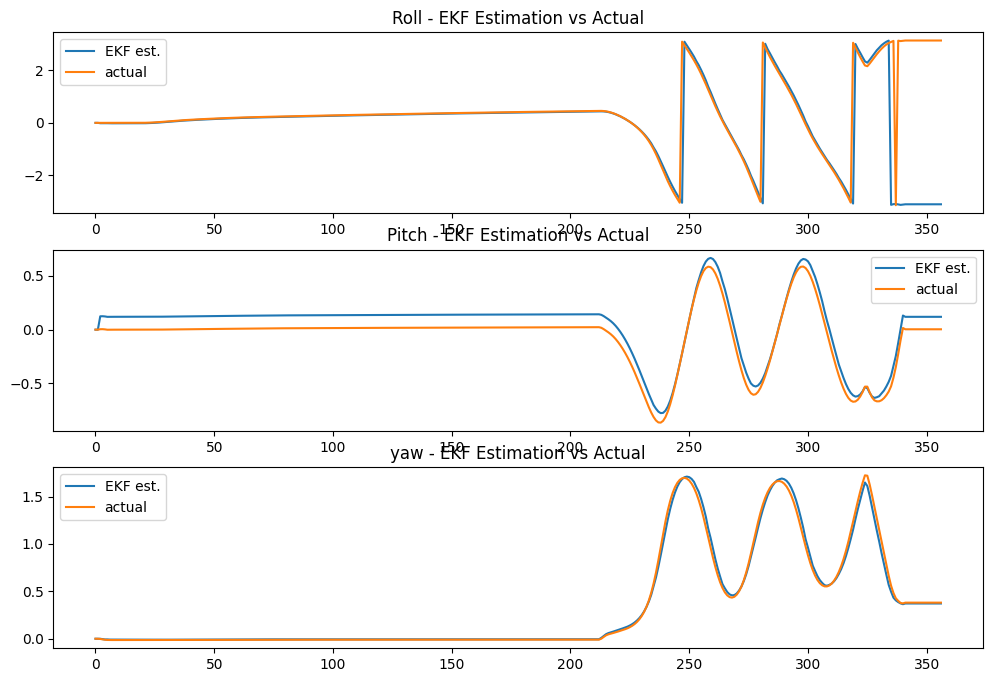

In [9]:
fig, ax = plt.subplots(3,1, figsize=(12,8))


ax[0].plot(range(0,len(roll_est)), roll_est, label='EKF est.')
ax[0].plot(range(0,len(ctx['eul_x_a'])), ctx['eul_x_a'], label='actual')
ax[0].set_title("Roll - EKF Estimation vs Actual")
ax[0].legend()

ax[1].plot(range(0,len(pitch_est)), pitch_est, label='EKF est.')
ax[1].plot(range(0,len(ctx['eul_y_a'])), ctx['eul_y_a'], label='actual')
ax[1].set_title("Pitch - EKF Estimation vs Actual")
ax[1].legend()

ax[2].plot(range(0,len(yaw_est)), yaw_est, label='EKF est.')
ax[2].plot(range(0,len(ctx['eul_z_a'])), ctx['eul_z_a'], label='actual')
ax[2].set_title("yaw - EKF Estimation vs Actual")
ax[2].legend()

plt.show()